# Video Frame Extraction Preprocessing

This notebook extracts frames from source videos and saves them for further processing.

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [9]:
# Configuration
VIDEO_PATH = 'source_videos/buddha.MOV'
OUTPUT_DIR = 'data/buddha'
FRAME_RATE = 1  # Extract 1 frame per second

In [10]:
def extract_frames(video_path, output_dir, fps=1):
    """
    Extract frames from a video at specified frame rate.
    
    Args:
        video_path: Path to the input video file
        output_dir: Directory to save extracted frames
        fps: Number of frames to extract per second (default: 1)
    """
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return
    
    # Get video properties
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / video_fps
    
    print(f"Video FPS: {video_fps}")
    print(f"Total frames: {total_frames}")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Extracting {fps} frame(s) per second...\n")
    
    # Calculate frame interval
    frame_interval = int(video_fps / fps)
    
    frame_count = 0
    saved_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Save frame at specified interval
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_dir, f'frame_{saved_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            saved_count += 1
            
            if saved_count % 10 == 0:
                print(f"Saved {saved_count} frames...")
        
        frame_count += 1
    
    cap.release()
    
    print(f"\nExtraction complete!")
    print(f"Total frames saved: {saved_count}")
    print(f"Frames saved to: {output_dir}")

In [11]:
# Extract frames from bunny.MOV
extract_frames(VIDEO_PATH, OUTPUT_DIR, FRAME_RATE)

Video FPS: 23.704426289476892
Total frames: 648
Duration: 27.34 seconds
Extracting 1 frame(s) per second...

Saved 10 frames...
Saved 20 frames...

Extraction complete!
Total frames saved: 28
Frames saved to: data/buddha


In [12]:
# Verify the extracted frames
frames = sorted(os.listdir(OUTPUT_DIR))
print(f"Number of frames extracted: {len(frames)}")
print(f"First few frames: {frames[:5]}")
print(f"Last few frames: {frames[-5:]}")

Number of frames extracted: 28
First few frames: ['frame_0000.jpg', 'frame_0001.jpg', 'frame_0002.jpg', 'frame_0003.jpg', 'frame_0004.jpg']
Last few frames: ['frame_0023.jpg', 'frame_0024.jpg', 'frame_0025.jpg', 'frame_0026.jpg', 'frame_0027.jpg']


## Quality Check: Brightness and Saturation Analysis

For photometric stereo, we need to check:
1. **Saturation** - Overexposed pixels (255 value) lose surface information
2. **Dynamic range** - Need detail in both highlights and shadows
3. **Consistent exposure** - All images should have similar brightness

In [13]:
def analyze_brightness_saturation(image_dir, sample_size=5):
    """
    Analyze brightness and saturation levels in extracted frames.
    
    Args:
        image_dir: Directory containing extracted frames
        sample_size: Number of sample images to analyze
    """
    frames = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
    
    if len(frames) == 0:
        print("No frames found!")
        return
    
    # Sample evenly distributed frames
    step = max(1, len(frames) // sample_size)
    sample_frames = frames[::step][:sample_size]
    
    print(f"Analyzing {len(sample_frames)} sample frames...\n")
    
    saturation_percentages = []
    mean_intensities = []
    
    for frame_name in sample_frames:
        img_path = os.path.join(image_dir, frame_name)
        img = cv2.imread(img_path)
        
        if img is None:
            continue
            
        # Convert to grayscale for analysis
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Check saturation (pixels at 255)
        saturated_pixels = np.sum(gray >= 254)
        total_pixels = gray.size
        saturation_pct = (saturated_pixels / total_pixels) * 100
        
        # Mean intensity
        mean_intensity = np.mean(gray)
        
        saturation_percentages.append(saturation_pct)
        mean_intensities.append(mean_intensity)
        
        print(f"{frame_name}:")
        print(f"  Mean intensity: {mean_intensity:.1f}/255")
        print(f"  Saturated pixels: {saturation_pct:.2f}%")
        
        # Warning if too much saturation
        if saturation_pct > 5:
            print(f"  ⚠️  WARNING: High saturation! May lose surface detail")
        print()
    
    # Overall statistics
    print("=" * 50)
    print("OVERALL STATISTICS:")
    print(f"Average mean intensity: {np.mean(mean_intensities):.1f}/255")
    print(f"Average saturation: {np.mean(saturation_percentages):.2f}%")
    print(f"Intensity std dev: {np.std(mean_intensities):.1f}")
    
    if np.mean(saturation_percentages) > 5:
        print("\n⚠️  HIGH SATURATION DETECTED!")
        print("Consider reducing exposure or using HDR techniques")
    
    if np.std(mean_intensities) > 20:
        print("\n⚠️  INCONSISTENT EXPOSURE!")
        print("Images have varying brightness - may need normalization")
    
    return saturation_percentages, mean_intensities

# Run analysis
sat_pct, mean_int = analyze_brightness_saturation(OUTPUT_DIR)

Analyzing 5 sample frames...

frame_0000.jpg:
  Mean intensity: 158.0/255
  Saturated pixels: 0.00%

frame_0005.jpg:
  Mean intensity: 167.2/255
  Saturated pixels: 0.00%

frame_0010.jpg:
  Mean intensity: 165.9/255
  Saturated pixels: 0.00%

frame_0015.jpg:
  Mean intensity: 122.1/255
  Saturated pixels: 0.00%

frame_0020.jpg:
  Mean intensity: 183.0/255
  Saturated pixels: 0.00%

OVERALL STATISTICS:
Average mean intensity: 159.3/255
Average saturation: 0.00%
Intensity std dev: 20.3

⚠️  INCONSISTENT EXPOSURE!
Images have varying brightness - may need normalization


## Visualize Sample Frames

Check that frames show different lighting directions and all elements are visible:
- Light probe (sphere)
- White balance sheet
- Bunny (object of interest)

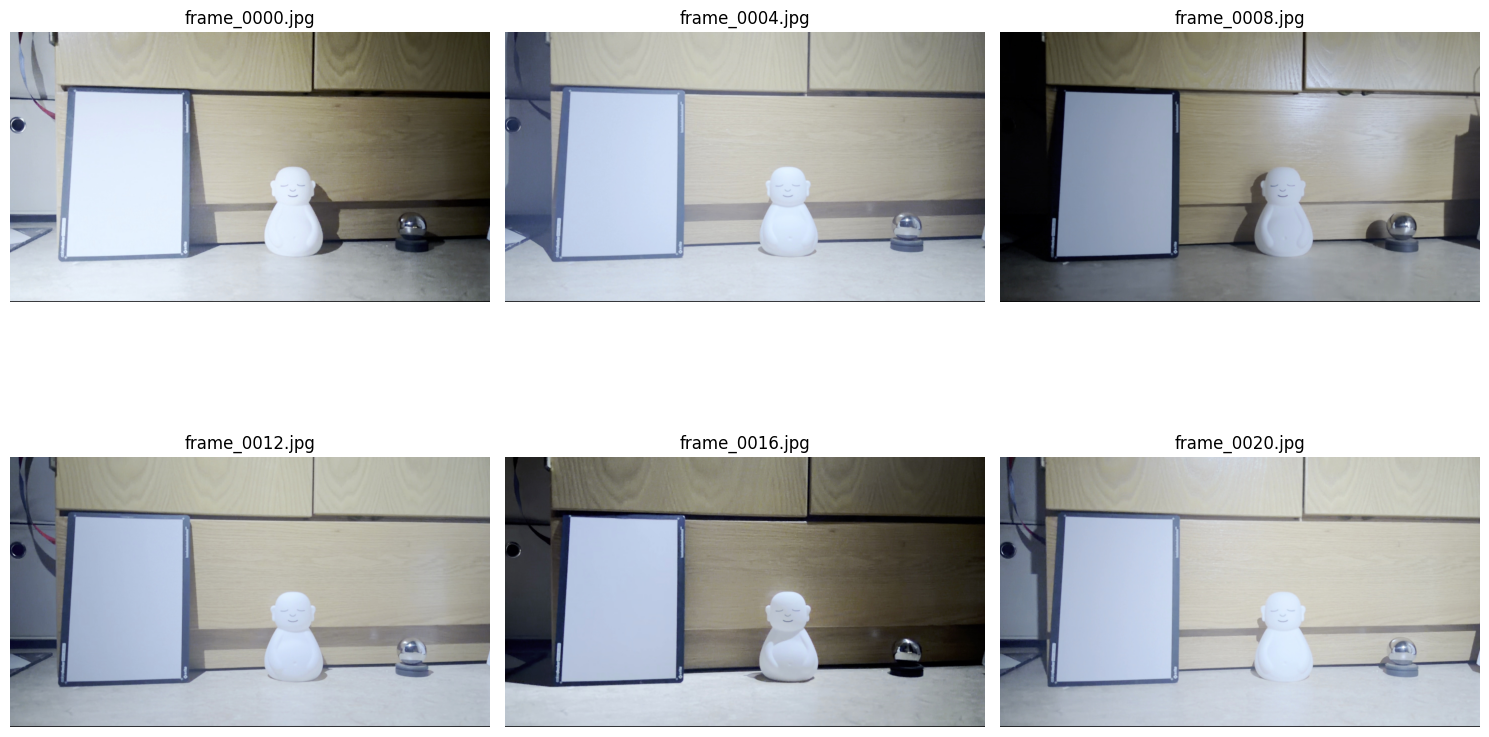

Displayed 6 sample frames
✓ Verify that lighting direction changes across frames
✓ Check that light probe, white balance sheet, and bunny are visible


In [14]:
def visualize_sample_frames(image_dir, num_samples=6):
    """Display sample frames to verify lighting variation."""
    frames = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
    
    step = max(1, len(frames) // num_samples)
    sample_frames = frames[::step][:num_samples]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, frame_name in enumerate(sample_frames):
        img_path = os.path.join(image_dir, frame_name)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f'{frame_name}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed {len(sample_frames)} sample frames")
    print("✓ Verify that lighting direction changes across frames")
    print("✓ Check that light probe, white balance sheet, and bunny are visible")

visualize_sample_frames(OUTPUT_DIR)

## Next Steps for Photometric Stereo Pipeline

Based on your setup, you'll need to create:

### 1. **Masks** (3 separate masks):
   - **Bunny mask** - Isolate the object of interest
   - **Light probe mask** - Identify the sphere for light direction calibration
   - **White balance mask** - Mark the white balance sheet for normalization

### 2. **Light Direction Calibration**:
   - Use Hough circle detection on the light probe
   - Find brightest point on sphere for each frame
   - Calculate 3D light direction vector

### 3. **Intensity Normalization**:
   - Use white balance sheet to normalize brightness across frames
   - Compensates for varying light intensities

### 4. **Shadow Detection** (optional but recommended):
   - Identify cast shadows that violate Lambertian assumptions
   - Exclude shadowed pixels from reconstruction

### Key Assumptions for Photometric Stereo:
- ✓ **Fixed camera** - Object doesn't move between frames
- ✓ **Lambertian surface** - Diffuse reflection (works well for stuffed animals)
- ✓ **Distant point lights** - Light direction is consistent across object
- ✓ **Different light directions** - Need at least 3, more is better (20+ ideal)